In [5]:
import pickle
import os

# Define your WESAD dataset path
dataset_path = r"D:\COAI_paper\WESAD\WESAD"

# Let's pick one subject, for example S2
subject_id = "S2"

# Path to the .pkl file
subject_file = os.path.join(dataset_path, subject_id, f"{subject_id}.pkl")

# Check if the file exists
if os.path.exists(subject_file):
    print(f"Found file: {subject_file}")
else:
    print(f"File not found: {subject_file}")

# Load the pickle file with correct encoding
with open(subject_file, 'rb') as file:
    data = pickle.load(file, encoding='latin1')

# Print keys to understand structure
print("\nKeys in the loaded data:")
print(data.keys())


# Explore inside chest and wrist
print("\nChest signal keys:", data['signal']['chest'].keys())
print("Wrist signal keys:", data['signal']['wrist'].keys())

# Now check shapes for specific signals
print("\nChest ECG shape:", data['signal']['chest']['ECG'].shape)
print("Chest EDA shape:", data['signal']['chest']['EDA'].shape)
print("Chest Respiration shape:", data['signal']['chest']['Resp'].shape)

# And some labels
print("\nFirst 20 labels:")
print(data['label'][:20])



Found file: D:\COAI_paper\WESAD\WESAD\S2\S2.pkl

Keys in the loaded data:
dict_keys(['signal', 'label', 'subject'])

Chest signal keys: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
Wrist signal keys: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])

Chest ECG shape: (4255300, 1)
Chest EDA shape: (4255300, 1)
Chest Respiration shape: (4255300, 1)

First 20 labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [6]:
# Print Label Distribution

In [7]:
import numpy as np

unique_labels, label_counts = np.unique(data['label'], return_counts=True)
print("\nLabel Distribution:")
for lbl, count in zip(unique_labels, label_counts):
    print(f"Label {lbl}: {count} samples")



Label Distribution:
Label 0: 2142701 samples
Label 1: 800800 samples
Label 2: 430500 samples
Label 3: 253400 samples
Label 4: 537599 samples
Label 6: 45500 samples
Label 7: 44800 samples


In [11]:
# Visualize Signal sample

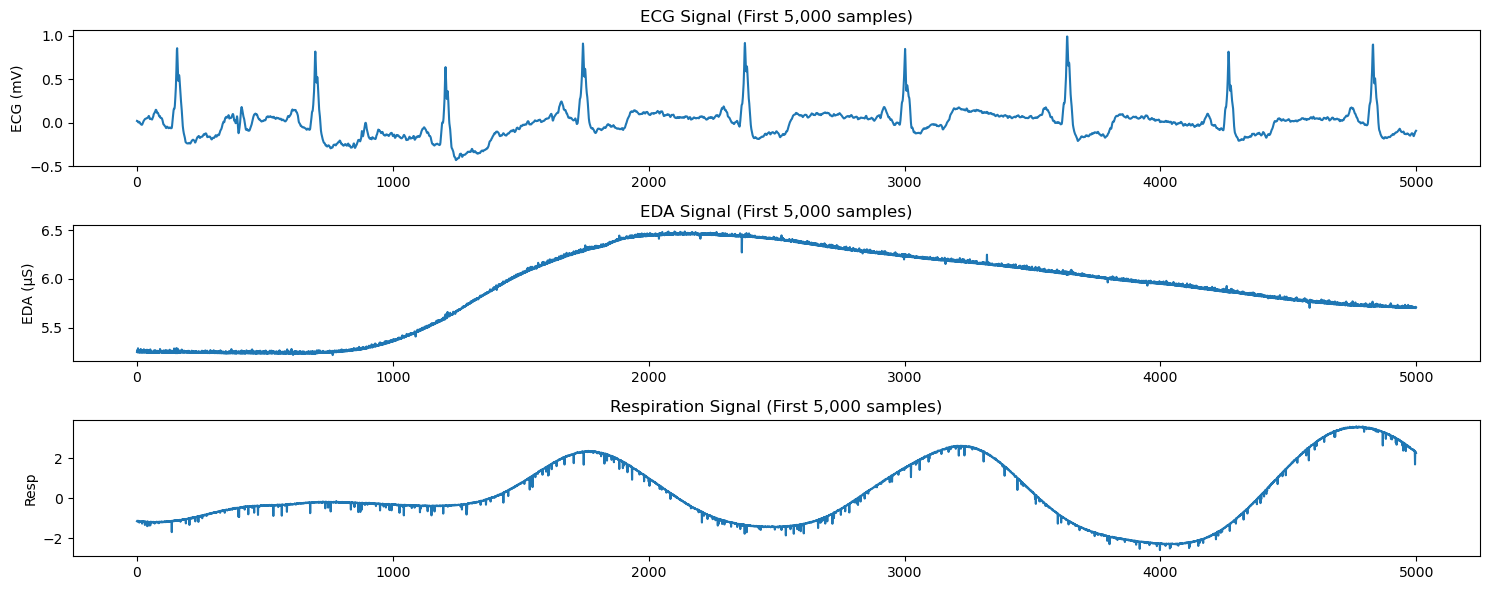

In [13]:
import matplotlib.pyplot as plt

ecg = data['signal']['chest']['ECG'][:5000, 0]
eda = data['signal']['chest']['EDA'][:5000]
resp = data['signal']['chest']['Resp'][:5000]

plt.figure(figsize=(15, 6))
plt.subplot(3, 1, 1)
plt.plot(ecg)
plt.title('ECG Signal (First 5,000 samples)')
plt.ylabel('ECG (mV)')

plt.subplot(3, 1, 2)
plt.plot(eda)
plt.title('EDA Signal (First 5,000 samples)')
plt.ylabel('EDA (μS)')

plt.subplot(3, 1, 3)
plt.plot(resp)
plt.title('Respiration Signal (First 5,000 samples)')
plt.ylabel('Resp')

plt.tight_layout()
plt.show()


In [14]:
#Plot Label Timeline

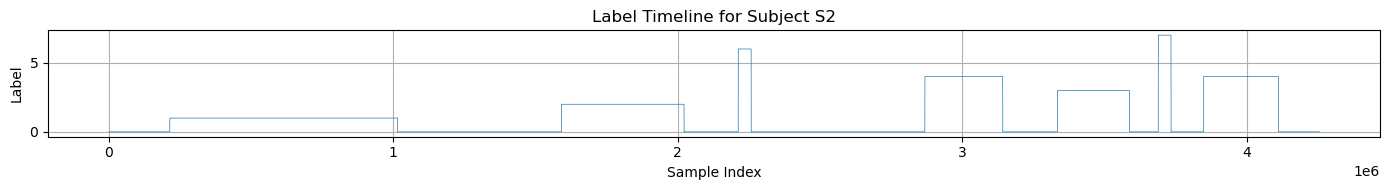

In [17]:
plt.figure(figsize=(14, 2))
plt.plot(data['label'], linewidth=0.5)
plt.title('Label Timeline for Subject S2')
plt.xlabel('Sample Index')
plt.ylabel('Label')
plt.grid(True)
plt.tight_layout()
plt.show()


# Windowing and Feature Extraction

In [20]:
# Clean Feature Extraction from Label 1 & 2 

In [22]:
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(data, cutoff=3.0, fs=700, order=4):
    b, a = butter(order, cutoff / (0.5 * fs), btype='low')
    return filtfilt(b, a, data)

def extract_features_windowed(data, window_size=1500, step_size=750):
    labels = data['label']
    ecg_raw = data['signal']['chest']['ECG']
    ecg = ecg_raw[:, 0] if ecg_raw.ndim == 2 else ecg_raw
    eda = data['signal']['chest']['EDA'][:, 0]
    resp = data['signal']['chest']['Resp'][:, 0]

    print("ECG shape:", ecg.shape)
    print("EDA shape:", eda.shape)
    print("RESP shape:", resp.shape)
    print("Label shape:", labels.shape)

    features, targets = [], []

    for start in range(0, len(labels) - window_size, step_size):
        end = start + window_size
        window_labels = labels[start:end]

        valid_ratio = np.isin(window_labels, [1, 2]).sum() / len(window_labels)
        if valid_ratio < 0.9:
            continue

        majority_label = np.bincount(window_labels[window_labels <= 2]).argmax()

        ecg_seg = ecg[start:end]
        eda_seg = eda[start:end]
        resp_seg = resp[start:end]

        try:
            ecg_filt = butter_lowpass_filter(ecg_seg)
            eda_filt = butter_lowpass_filter(eda_seg)
            resp_filt = butter_lowpass_filter(resp_seg)
        except Exception:
            continue

        feat = [
            np.mean(ecg_filt), np.std(ecg_filt),
            np.mean(eda_filt), np.std(eda_filt),
            np.mean(resp_filt), np.std(resp_filt)
        ]
        features.append(feat)
        targets.append(majority_label)

    return np.array(features), np.array(targets)


In [24]:
X, y = extract_features_windowed(data)

print(f"✅ Feature matrix shape: {X.shape}")
print(f"✅ Label vector shape: {y.shape}")
print("✅ Label distribution:", dict(zip(*np.unique(y, return_counts=True))))


ECG shape: (4255300,)
EDA shape: (4255300,)
RESP shape: (4255300,)
Label shape: (4255300,)
✅ Feature matrix shape: (1640, 6)
✅ Label vector shape: (1640,)
✅ Label distribution: {1: 1067, 2: 573}


# Feature Visualization

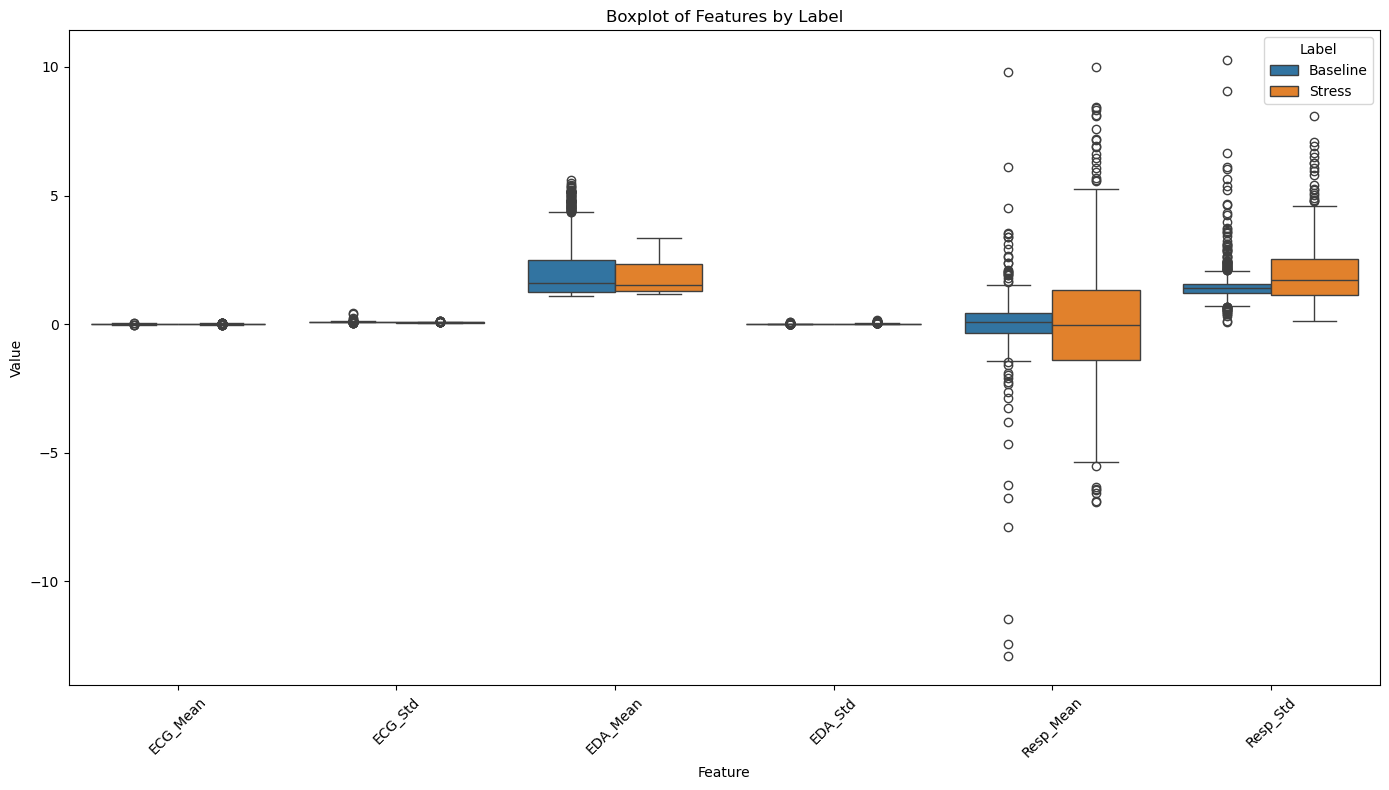

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Prepare DataFrame for plotting
df_viz = pd.DataFrame(X, columns=[
    'ECG_Mean', 'ECG_Std', 'EDA_Mean', 'EDA_Std', 'Resp_Mean', 'Resp_Std'
])
df_viz['Label'] = y
df_viz['Label'] = df_viz['Label'].map({1: 'Baseline', 2: 'Stress'})

# 📊 Boxplot: Distribution of each feature by class
plt.figure(figsize=(14, 8))
sns.boxplot(data=pd.melt(df_viz, id_vars='Label'), x='variable', y='value', hue='Label')
plt.title('Boxplot of Features by Label')
plt.ylabel('Value')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




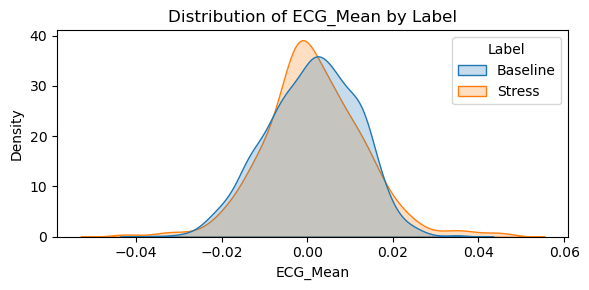

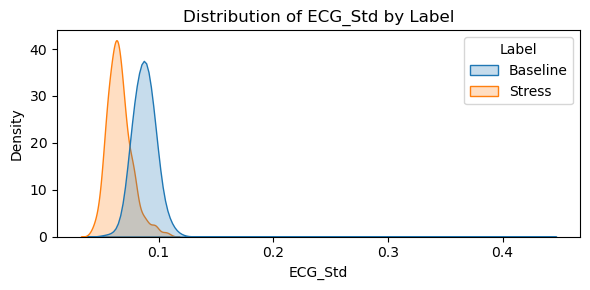

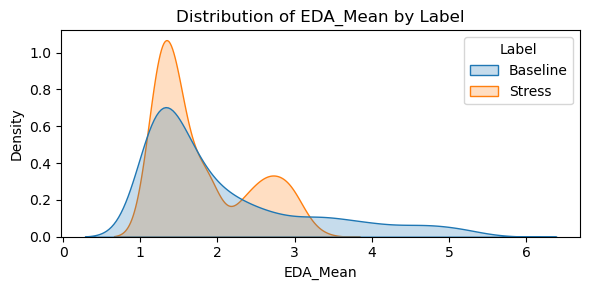

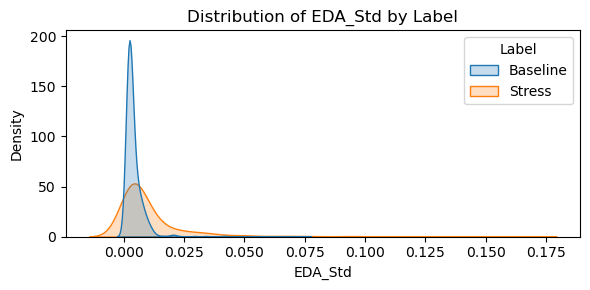

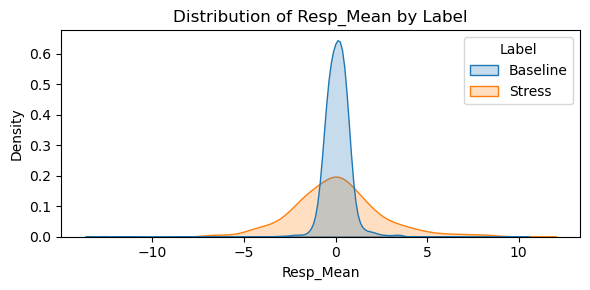

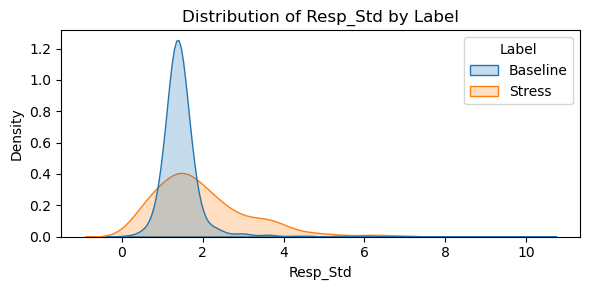

In [29]:
# 📈 Histogram (KDE): Distribution of each feature
for col in df_viz.columns[:-1]:
    plt.figure(figsize=(6, 3))
    sns.kdeplot(data=df_viz, x=col, hue='Label', fill=True, common_norm=False)
    plt.title(f'Distribution of {col} by Label')
    plt.tight_layout()
    plt.show()



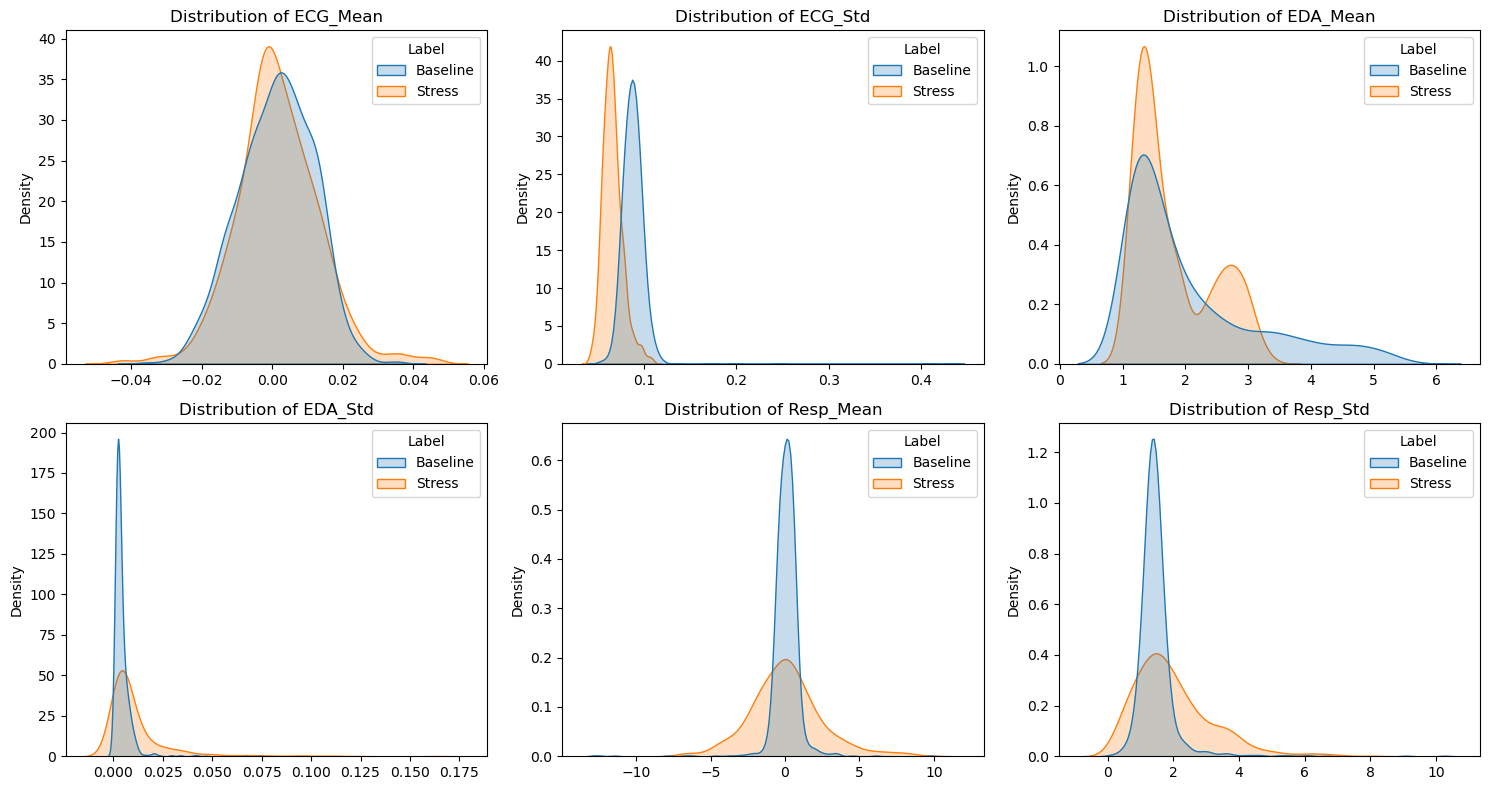

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Create DataFrame
df_viz = pd.DataFrame(X, columns=[
    'ECG_Mean', 'ECG_Std', 'EDA_Mean', 'EDA_Std', 'Resp_Mean', 'Resp_Std'
])
df_viz['Label'] = y
df_viz['Label'] = df_viz['Label'].map({1: 'Baseline', 2: 'Stress'})

# Set up the figure
fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # 2 rows x 3 columns
axes = axes.flatten()  # Flatten to loop easily

# Plot each feature
for i, col in enumerate(df_viz.columns[:-1]):
    sns.kdeplot(data=df_viz, x=col, hue='Label', fill=True, common_norm=False, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Density')

# Adjust layout and spacing
plt.tight_layout()
#plt.suptitle("Feature Distributions by Class Label", fontsize=16, fontweight='bold', y=1.02)
plt.savefig("W2.png", dpi=300, bbox_inches='tight')
plt.show()


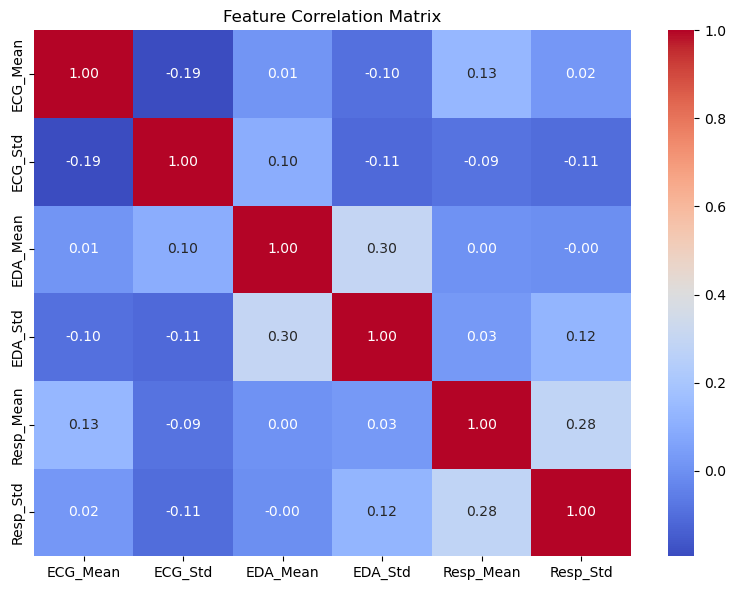

In [27]:
# 🔗 Correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df_viz.drop(columns='Label').corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()
# We observed low inter-feature correlation, indicating minimal redundancy across physiological domains. 
#Notably, EDA-based features showed moderate internal correlation (r ≈ 0.30), while ECG and respiratory metrics remained largely independent. 
#This supports the use of multi-modal fusion in our stress classification pipeline

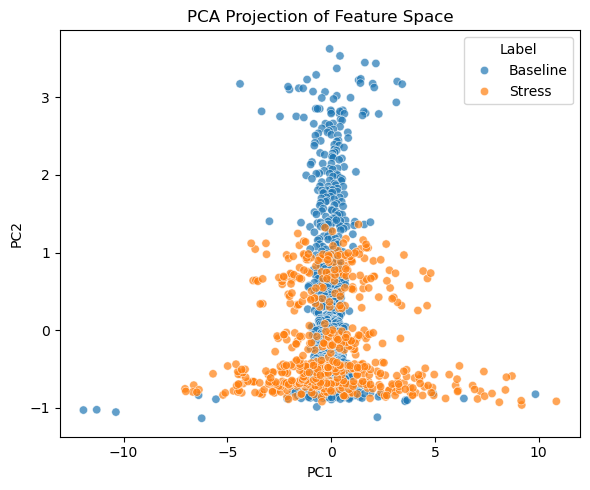

In [29]:


# 🌐 PCA (Optional): Visualize class separation in 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_viz['Label'], alpha=0.7)
plt.title('PCA Projection of Feature Space')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

# Train 5 ML Models and Visualize Evaluation Results

In [48]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    RocCurveDisplay, f1_score, precision_score, recall_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


In [ ]:
# Class Weighting + SMOTE Oversampling

In [ ]:
############3